### 2d problem

Use data from: http://db.csail.mit.edu/labdata/labdata.html

- **Was not able to load the site. Using random synthesized temperature data** 
- **SKlearn GP for 3 dimentions not trivial**

In [108]:
# imports for 3d plots
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [109]:
def f2d(x, y):
    return 2*((x-3)*np.sin(x-3)) + 2 - 0.5*x + np.cos(y+3) + y**(1.2)

In [110]:
# Showing the data
granularity = 20
X = np.linspace(0, 10, granularity)
Y = np.linspace(0, 10, granularity)

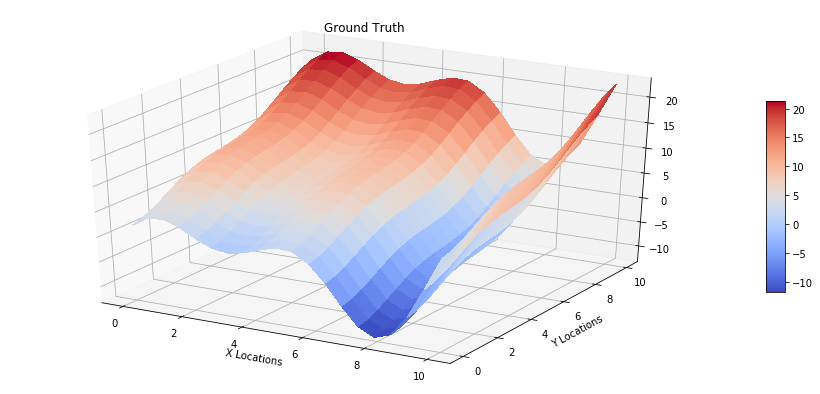

In [112]:
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
XX, YY = np.meshgrid(X, Y)
Z = f2d(XX, YY)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title("Ground Truth")
ax.set_xlabel("X Locations")
ax.set_ylabel("Y Locations")
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

@ TODO below.

Now we have 2D data!

In [113]:
# https://matplotlib.org/3.1.0/gallery/mplot3d/subplot3d.html

fig = plt.figure(figsize=(18, 6))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
XX, YY = np.meshgrid(X, Y)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
XX, YY, Z = get_test_data(0.05)
ax.plot_wireframe(XX, YY, Z, rstride=10, cstride=10)

plt.show()

In [106]:
XY = np.array([XX.flatten(), YY.flatten()]).T # all points
x = XY

array([[ 0.,  0.],
       [10.,  0.],
       [ 0., 10.],
       [10., 10.]])

In [116]:
x[1]

array([10.,  0.])

In [ ]:
def plot_acquisition2d(
        train_X, train_y,
        acq_class, acq_params={},
        ylim0=None, xlim0=None,
        ylim1=None, xlim1=None,
        y1scale='linear', it = 10,
        seed = 2
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        
        # https://matplotlib.org/3.1.0/gallery/mplot3d/subplot3d.html

        fig = plt.figure(figsize=(18, 6))

        #===============
        #  First subplot
        #===============
        # set up the axes for the first plot
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        # plot a 3D surface like in the example mplot3d/surface3d_demo
        XX, YY = np.meshgrid(X, Y)
        surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        # ax.set_zlim(-1.01, 1.01)
        fig.colorbar(surf, shrink=0.5, aspect=10)

        #===============
        # Second subplot
        #===============
        # set up the axes for the second plot
        ax = fig.add_subplot(1, 2, 2, projection='3d')

        # plot a 3D wireframe like in the example mplot3d/wire3d_demo
        XX, YY, Z = get_test_data(0.05)
        ax.plot_wireframe(XX, YY, Z, rstride=10, cstride=10)

        plt.show()

        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[1].set_yscale(y1scale)
        
        # limits
        ax[0].set_ylim(ylim0) if ylim0 is not None else ax[0].set_ylim(min(f(x)-.5), max(f(x))+.5)
        ax[0].set_xlim(xlim0) if xlim0 is not None else ax[0].set_xlim(min(x)-.5, max(x)+.5)
        ax[1].set_ylim(ylim1) if ylim1 is not None else None
        ax[1].set_xlim(xlim1) if xlim1 is not None else ax[1].set_xlim(min(x)-.5, max(x)+.5)
        
        
        # fitting
        gp.fit(train_X, train_y.flatten())
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, x, t=i+1, **acq_params, train_y=train_y)
        ax[1].plot(x, acquisition, 
                   label='Acquisition function', color='green')
        
        # predict on current pool set
        y_pred, sigma = gp.predict(x, return_std=True)
        ax[0].plot(x, y_pred, 'k', label='Predicted')
        ax[0].plot(x, f(x), 'purple', label='GT')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Gold content")
        ax[0].fill_between(x.flatten(), y_pred+sigma,
                           y_pred-sigma, color='gray',
                           alpha=0.2, label=r'$\mu \pm \sigma$')
        ax[0].scatter(train_X, train_y, color='black', s=100, zorder=10, label='Train points')
        ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax[1].set_ylabel(str(acq_obj))
        hyperparams = ' | '.join([str(k)+': '+str(v) for k, v in acq_params.items()])
        ax[0].set_title(f"Iteration: {i} & HParam(s) → " + hyperparams)
        
        # Choose the next point with highest sigma
        max_mu = np.max(train_y).flatten()[0]
        next_ix = rargmax(acquisition)
        next_x = x[next_ix]

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(x[next_ix], acquisition[next_ix], marker='X',s=50,
                      c='orange', zorder=10, label='maxima (tie randomly broken)')
        ax[0].scatter(x[next_ix], f(x[next_ix]), color='red',
                      s=200, zorder=-10, label='New Added points')
        ax[0].legend(bbox_to_anchor=(1.1,1), loc="upper left")
        ax[1].legend(bbox_to_anchor=(1.1,0.5), loc="upper left")
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)
        max_till_now.append(np.argmax(train_y))
        format_axes(ax[0])
        format_axes(ax[1])

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/'+str(acq_obj)+'/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight")
        plt.close()
    return dirName, max_till_now

In [46]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [47]:
gp = GaussianProcessRegressor()

In [48]:
import numpy as np

In [49]:
X = np.random.randn(10, 2)

In [50]:
X.shape

(10, 2)

In [52]:
y = np.ones(10)
y.shape

(10,)

In [53]:
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [54]:
gp.predict([[2, 4]])

array([0.06673904])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
Z.shape

In [ ]:
gp.f